In [1]:
%pylab inline
import pandas as pd
from matplotlib.colors import LogNorm
from scipy.optimize import fsolve

Populating the interactive namespace from numpy and matplotlib


# 全局的参数

In [2]:
global h,Om
h,Om=0.7,0.3

In [3]:
# 根据望远镜极限，求dmax
def dist_max(data,Mag_name,obs_lim=23):
    return 10**((obs_lim-data[Mag_name].values-25)/5)

In [4]:
def comoving_dist(z,h=h,Om=Om):
    a=6243.3/(h*Om**0.395)
    b=1/(1+0.47*Om)**0.105
    c=1/((1+z)**0.185*(1-Om+1.47*Om*(1+z)**3)**0.105)
    return a*(b-c)

In [5]:
def get_z_from_Luminosity_dist(data,dist_band,h=h,Om=Om):
    z=[]
    for i in range(len(data)):
        dist=data[dist_band].values[i]
        ## 定义一个符合求解规范的方程
        def func(z,L_d=dist,h=h,Om=Om):
            a=6243.3/(h*Om**0.395)
            b=1/(1+0.47*Om)**0.105
            c=1/((1+z)**0.185*(1-Om+1.47*Om*(1+z)**3)**0.105)
            return (1+z)*a*(b-c)-dist
        ## 使用scipy.optimize.fsolve得到反解出的zmax
        z_solve=fsolve(func,0)[0]
        z.append(z_solve)
    return z

In [91]:
def get_Vmax(data,fsky_degree,zmax_col,z_col,zmin_survey,zmax_survey):
    # Vmax_1=1/Vmax
    zmax=np.minimum(data[zmax_col].values,zmax_survey)
    all_sky_degree=(np.pi/180)**2/(4*np.pi)
    fsky=fsky_degree*all_sky_degree
    Vmax=fsky/3*(comoving_dist(zmax)**3-comoving_dist(zmin_survey)**3)
    Vmax_1=1/Vmax
    return Vmax,Vmax_1

In [7]:
def get_lunf(data,band_name,Vmax_inverse_name,xmin,xmax,dx):
    phi_x=[]
    x_center=[]
    x=xmin
    while x<xmax:
        l,r=x-0.5*dx,x+0.5*dx
        temp=data[(data[band_name]<r)&(data[band_name]>l)].copy()
        phi=sum(temp[Vmax_inverse_name].values)
        x_center.append(x)
        phi_x.append(phi)
        x+=dx
    return x_center,phi_x

In [58]:
def get_LB(MB,MsunB=5.48,LsunB=4.67):
    return (MsunB-MB)/2.5+log10(LsunB)

# 旧的CMASS数据

In [8]:
def Luminous_d(z,h=h,Om=Om):
    ## output in the unit of Mpc
    ## from zhiqi Huagn
    a=6243.3/(h*Om**0.395)
    b=1/(1+0.47*Om)**0.105
    c=1/((1+z)**0.185*(1-Om+1.47*Om*(1+z)**3)**0.105)
    return (1+z)*a*(b-c)

def read_data(loc):
    # M = m + 5 - 5lgr
    # r in the unit of pc, dL in the unit of Mpc
    # M = m - 25 - 5lgdL
    # 在UBVRI系统中，B波段的太阳的星等为5.48
    # 光度以太阳的光度为单位
    # 加入了k-correction
    
    data=pd.read_csv(loc,dtype={'specObjID':str, 'ra':np.float64, 'dec':np.float64, 'z':np.float64,
                                'type':str, 'objID':str, 'modelMag_u':np.float64,'modelMag_g':np.float64, 'modelMag_r':np.float64, 'modelMag_i':np.float64, 'modelMag_z':np.float64})
    ls=[]
    for i in data.z.values:
        ls.append(Luminous_d(i))
    data['dL']=ls
    data['Abs_mag_g']=data.modelMag_g.values-5*log10(data.dL.values)-25-2.5*log10(1+data.z.values)
    data['Abs_mag_r']=data.modelMag_r.values-5*log10(data.dL.values)-25-2.5*log10(1+data.z.values)
    data['Abs_mag_i']=data.modelMag_i.values-5*log10(data.dL.values)-25-2.5*log10(1+data.z.values)
    data['Abs_mag_B']=data.Abs_mag_g+0.39*(data.Abs_mag_g-data.Abs_mag_r)+0.21
    data['Abs_mag_V']=data.Abs_mag_g-0.59*(data.Abs_mag_g-data.Abs_mag_r)-0.01
    data['colorBV']=data.Abs_mag_B-data.Abs_mag_V
    return data

In [47]:
south=read_data('galaxy_DR12v5_CMASS_South.fits.all.no_repeat.csv')
north=read_data('galaxy_DR12v5_CMASS_North.fits.all.no_repeat.csv')
data=pd.concat([south,north],axis=0)
data=data[(data.z<0.7)&(data.z>0.4)].copy()

In [13]:
### 在前面的步骤中，已经得到了绝对星等
### 下面计算的是i band, r band, B band的光度函数
 
# 求出dmax
data['dmax_r']=dist_max(data,'Abs_mag_r',obs_lim=23.1)
data['dmax_B']=dist_max(data,'Abs_mag_B',obs_lim=23.1)
data['dmax_i']=dist_max(data,'Abs_mag_i',obs_lim=22.3)
# 反解出zmax，得到zmax和rmax
z=get_z_from_Luminosity_dist(data,'dmax_r',h=h,Om=Om)
data['zmax_r']=z
z=get_z_from_Luminosity_dist(data,'dmax_B',h=h,Om=Om)
data['zmax_B']=z
z=get_z_from_Luminosity_dist(data,'dmax_i',h=h,Om=Om)
data['zmax_i']=z

In [14]:
# 计算出Vmax
fsky=9376 # BOSS CMASS大概是9376平方度
data['Vmax_r'],data['1_Vmax_r']=get_Vmax(data,fsky,'zmax_r','z',zmin_survey=0.4,zmax_survey=0.7)
data['Vmax_B'],data['1_Vmax_B']=get_Vmax(data,fsky,'zmax_B','z',zmin_survey=0.4,zmax_survey=0.7)
data['Vmax_i'],data['1_Vmax_i']=get_Vmax(data,fsky,'zmax_i','z',zmin_survey=0.4,zmax_survey=0.7)

In [15]:
data[['Vmax_r','Vmax_B','Vmax_i']].describe()

,Vmax_r,Vmax_B,Vmax_i
count,7.836130e+05,7.836130e+05,7.836130e+05
mean,9.079392e+08,6.672509e+08,9.079412e+08
std,7.491503e+05,2.755131e+08,2.873661e-03
min,5.284581e+08,-2.843944e+08,9.079412e+08
25%,9.079412e+08,4.682678e+08,9.079412e+08
50%,9.079412e+08,7.706009e+08,9.079412e+08
75%,9.079412e+08,9.079412e+08,9.079412e+08
max,9.079412e+08,9.079412e+08,9.079412e+08


# 计算不同红移下的结果

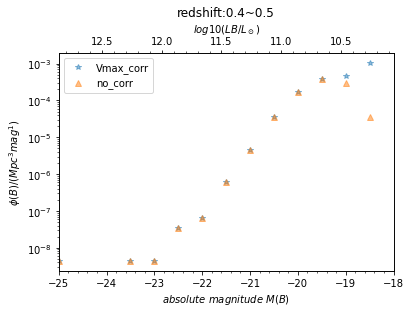

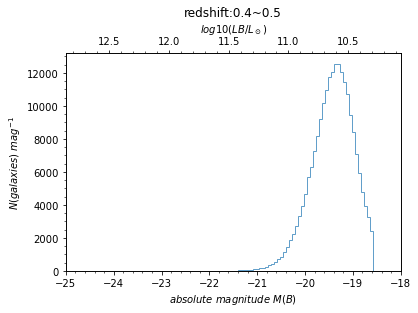

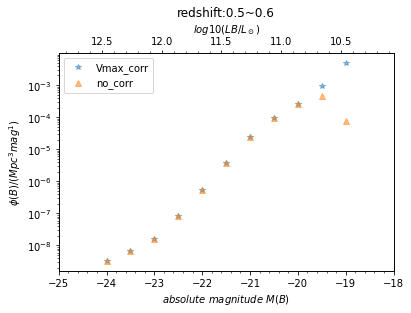

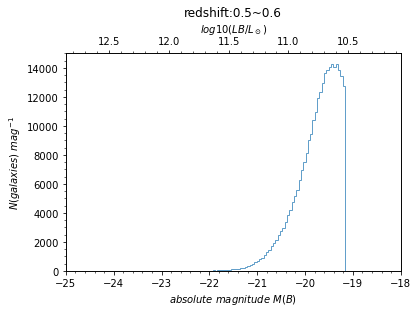

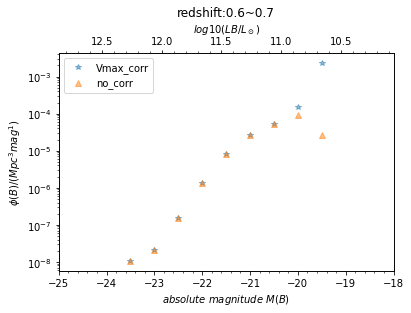

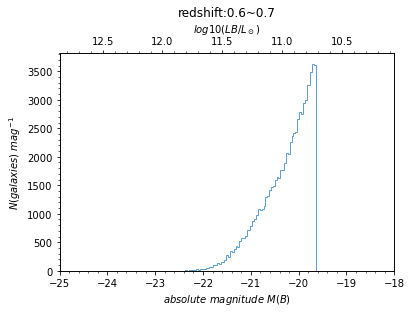

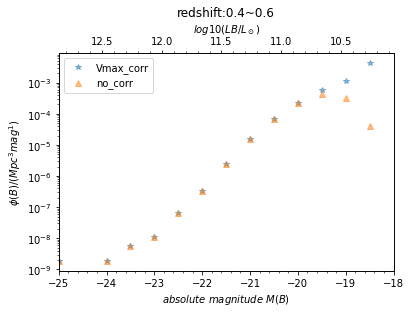

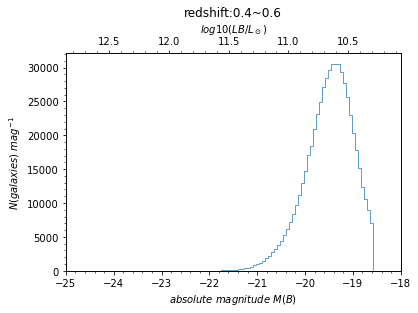

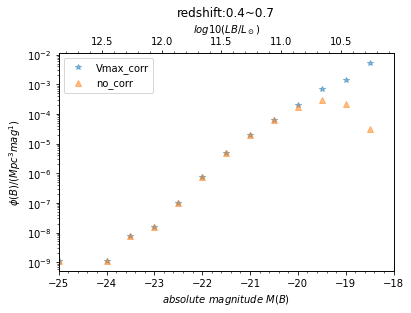

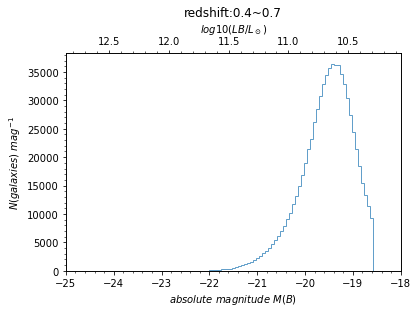

In [101]:
z_ls=[(0.4,0.5),(0.5,0.6),(0.6,0.7),(0.4,0.6),(0.4,0.7)]
# z_ls=[(0.4,0.5)]
xlim_l,xlim_r=-25,-18
for i in range(len(z_ls)):
    zmin,zmax=z_ls[i][0],z_ls[i][1]
    # 计算出Vmax
    fsky=9376 # BOSS CMASS大概是9376平方度
    temp=data[(data.z<zmax)&(data.z>zmin)&(data.zmax_B>zmin)].copy()
    temp['Vmax_B'],temp['1_Vmax_B']=get_Vmax(temp,fsky,'zmax_B','z',zmin_survey=zmin,zmax_survey=zmax)
    V_const=fsky*(np.pi/180)**2/(4*np.pi)/3*(comoving_dist(zmax)**3-comoving_dist(zmin)**3)
    temp['V_const']=V_const
    temp['1_V_const']=1/V_const
    plt.figure(figsize=(9,6))
    x_center,phi_x=get_lunf(temp,'Abs_mag_B','1_Vmax_B',xlim_l,xlim_r,0.5)
    plot(x_center,phi_x,'*',alpha=0.5,label='Vmax_corr')
    x_center,phi_x=get_lunf(temp,'Abs_mag_B','1_V_const',xlim_l,xlim_r,0.5)
    plot(x_center,phi_x,'^',alpha=0.5,label='no_corr')
    yscale('log')
    xlim(xlim_l,xlim_r)
#     ylabel('$\phi(B)/(Mpc^{-3}mag^{-1})$')
    ylabel('$\phi(B)/(Mpc^{3}mag^{1})$')
    xlabel('$absolute\ magnitude\ M(B)$')
    legend()
#     grid()
    minorticks_on()
    twiny()
    xlabel('$log10(LB/L_\odot)$')
    xlim(get_LB(xlim_l),get_LB(xlim_r))
#     tight_layout()
    minorticks_on()
    title('redshift:'+str(zmin)+'~'+str(zmax))
    plt.savefig('result/'+'phiB_redshift_'+str(zmin)+'_'+str(zmax)+'.png')
    plt.figure(figsize=(6,4))
    hist(temp.Abs_mag_B,bins=100,histtype='step',alpha=0.7)
    title('redshift:'+str(zmin)+'~'+str(zmax))
    xlabel('$absolute\ magnitude\ M(B)$')
    ylabel('$N(galaxies)\ mag^{-1}$')
    xlim(xlim_l,xlim_r)
    minorticks_on()
    twiny()
    xlabel('$log10(LB/L_\odot)$')
    xlim(get_LB(xlim_l),get_LB(xlim_r))
    minorticks_on()
    plt.savefig('result/'+'NB_redshift_'+str(zmin)+'_'+str(zmax)+'.png')
    show()